<a href="https://colab.research.google.com/github/CrisJurado10/API_JSON_SoocerVison/blob/main/MCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Bibliotecas de Scikit-learn para clustering y preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Para una mejor visualización en 3D
from mpl_toolkits.mplot3d import Axes3D

#  Silenciar advertencias futuras, útil en notebooks
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas importadas exitosamente.")

Bibliotecas importadas exitosamente.


In [2]:
# --- Carga de Datos ---
# URL directa al archivo Excel del dataset de UCI
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

# Cargar el dataset.
try:
    df = pd.read_excel(data_url)
    print(f"Dataset cargado: {df.shape[0]} filas y {df.shape[1]} columnas.")
except Exception as e:
    print(f"Error al cargar el dataset: {e}")
    # Si la URL falla, podrías tener una copia local:
    # df = pd.read_excel("Online Retail.xlsx")

# Mostrar las primeras filas
df.head()

Dataset cargado: 541909 filas y 8 columnas.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# --- Exploración y Limpieza Básica ---

# Ver información y tipos de datos
df.info()

# Revisar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB

Valores nulos por columna:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


Observaciones de la exploración:

InvoiceDate es de tipo datetime, lo cual es bueno.

CustomerID tiene una cantidad significativa de valores nulos. Dado que no podemos segmentar clientes sin su ID, debemos eliminar estas filas.

Description también tiene algunos nulos, pero no usaremos esa columna para RFM,así que no es un problema.

In [4]:
# --- Limpieza de Datos ---

# 1. Eliminar filas donde CustomerID es nulo
df_cleaned = df.dropna(subset=['CustomerID'])
print(f"Filas después de eliminar CustomerID nulos: {df_cleaned.shape[0]}")

# 2. Convertir CustomerID a tipo 'int' (ahora que no hay nulos)
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)

# 3. Eliminar transacciones con Cantidad (Quantity) negativa
# Estas suelen ser devoluciones o cancelaciones y no reflejan gasto.
df_cleaned = df_cleaned[df_cleaned['Quantity'] > 0]
print(f"Filas después de eliminar cantidades negativas: {df_cleaned.shape[0]}")

# 4. Asegurarse de que no haya precios unitarios negativos
df_cleaned = df_cleaned[df_cleaned['UnitPrice'] > 0]
print(f"Filas después de eliminar precios negativos: {df_cleaned.shape[0]}")

# Revisar estadísticas descriptivas
df_cleaned.describe()

Filas después de eliminar CustomerID nulos: 406829
Filas después de eliminar cantidades negativas: 397924
Filas después de eliminar precios negativos: 397884


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,397884.000000,397884,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000
std,179.331775,NaN,22.097877,1713.141560


Ahora, calculamos las métricas de Recency, Frequency y Monetary para cada cliente.

Recency (R): ¿Cuán recientemente compró un cliente? (Días desde la última compra).

Frequency (F): ¿Con qué frecuencia compra un cliente? (Número total de transacciones).

Monetary (M): ¿Cuánto gasta un cliente? (Valor monetario total).

In [5]:
# --- Ingeniería de Características ---

# 1. Calcular el valor Monetario (Total) para cada transacción
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

# 2. Determinar la "fecha de hoy" para el análisis de Recency.
# Usamos un día después de la última transacción en el dataset.
snapshot_date = df_cleaned['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"Fecha de referencia (Snapshot Date): {snapshot_date.strftime('%Y-%m-%d')}")

# 3. Agregar los datos por Cliente (CustomerID)
rfm_df = df_cleaned.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum')
)

# Reiniciar el índice para tener CustomerID como columna (opcional pero útil)
rfm_df = rfm_df.reset_index().astype(int)

print("\nDataFrame RFM inicial (primeras 5 filas):")
rfm_df.head()

Fecha de referencia (Snapshot Date): 2011-12-10

DataFrame RFM inicial (primeras 5 filas):


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183
1,12347,2,7,4310
2,12348,75,4,1797
3,12349,19,1,1757
4,12350,310,1,334


**Normalización de Características**
Las métricas RFM tienen escalas y distribuciones muy diferentes (ej. Monetary puede ir de 10 a 100,000, mientras que Frequency de 1 a 50). K-Means es sensible a estas escalas.

Además, los datos de RFM casi siempre están muy sesgados (skewed). Usar StandardScaler directamente sobre datos sesgados puede no ser óptimo.

Pro-tip de senior: Aplicamos una transformación logarítmica (log1p para manejar ceros) para reducir el sesgo, y luego escalamos los datos.

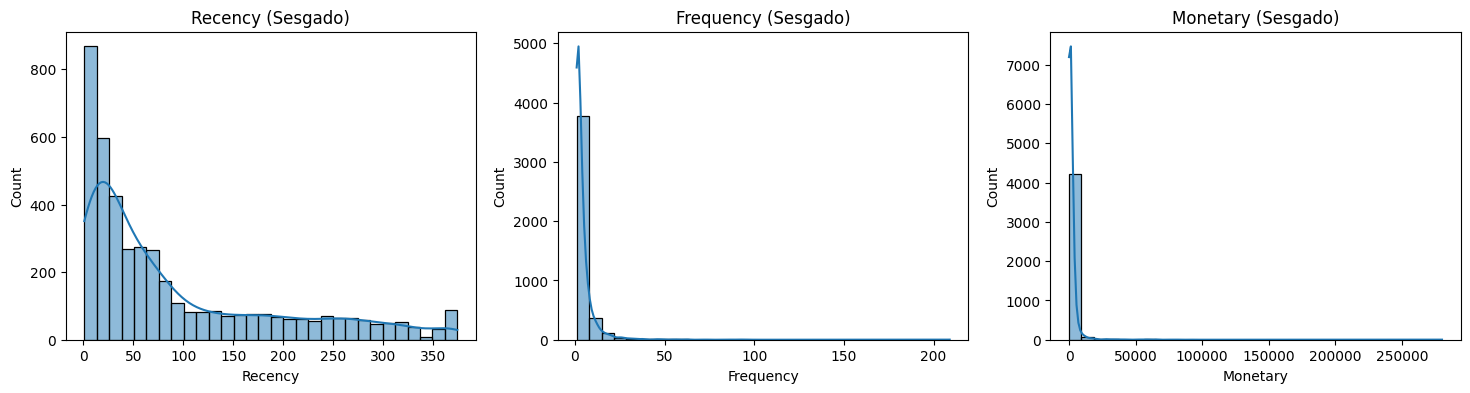

Datos escalados (primeras 5 filas):


,Recency,Frequency,Monetary
0,1.461993,-0.955214,3.702713
1,-2.038734,1.074425,1.411167
2,0.373104,0.386304,0.716564
3,-0.623086,-0.955214,0.698693
4,1.424558,-0.955214,-0.618083


In [6]:
# --- Visualización del Sesgo (Skewness) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(rfm_df['Recency'], bins=30, kde=True, ax=axes[0]).set_title('Recency (Sesgado)')
sns.histplot(rfm_df['Frequency'], bins=30, kde=True, ax=axes[1]).set_title('Frequency (Sesgado)')
sns.histplot(rfm_df['Monetary'], bins=30, kde=True, ax=axes[2]).set_title('Monetary (Sesgado)')
plt.show()

# --- Transformación Logarítmica ---
# Usamos np.log1p que equivale a log(x+1) para manejar valores de 0
rfm_log = pd.DataFrame()
rfm_log['Log_Recency'] = np.log1p(rfm_df['Recency'])
rfm_log['Log_Frequency'] = np.log1p(rfm_df['Frequency'])
rfm_log['Log_Monetary'] = np.log1p(rfm_df['Monetary'])

# --- Escalado (Normalización) ---
# Ahora escalamos los datos transformados
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# Convertir de nuevo a un DataFrame para facilidad de uso
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

print("Datos escalados (primeras 5 filas):")
rfm_scaled_df.head()

**Determinación del número óptimo de clusters (k)**
Usamos el Método del Codo (Elbow Method). Graficamos la inercia (suma de las distancias al cuadrado de las muestras a su centro de clúster más cercano) para diferentes valores de k. Buscamos el "codo" donde la tasa de disminución de la inercia se ralentiza bruscamente.

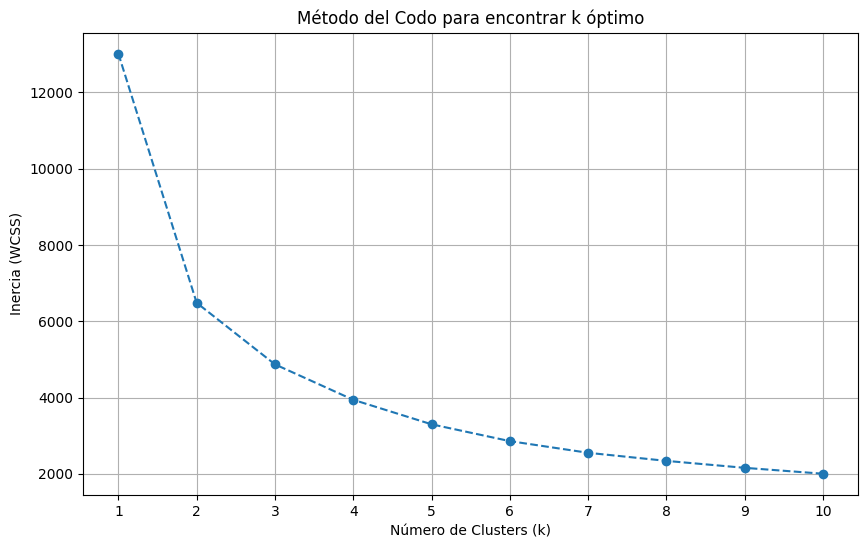

In [7]:
# --- Método del Codo (Elbow Method) ---
inertia = []
range_k = range(1, 11)  # Probamos k de 1 a 10

for k in range_k:
    kmeans = KMeans(n_clusters=k,
                    init='k-means++',    # Método de inicialización inteligente
                    n_init=10,           # Ejecutar 10 veces con diferentes centroides
                    max_iter=300,        # Iteraciones máximas
                    random_state=42)     # Para reproducibilidad
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

# --- Graficar el Codo ---
plt.figure(figsize=(10, 6))
plt.plot(range_k, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.title('Método del Codo para encontrar k óptimo')
plt.xticks(range_k)
plt.grid(True)
plt.show()

**Análisis del Codo:** El gráfico muestra un "codo" claro alrededor de k=4. Después de 4, la disminución de la inercia se vuelve mucho más gradual. Por lo tanto, seleccionamos k=4 para nuestro modelo.

**Aplicación de K-Means**
Ahora, aplicamos K-Means usando nuestro k óptimo (k=4).

In [8]:
# --- Aplicar K-Means con k=4 ---
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=42)

# Ajustar y predecir los clusters
clusters = kmeans.fit_predict(rfm_scaled_df)

# Añadir la etiqueta del cluster al DataFrame RFM original (no escalado)
rfm_df['Cluster'] = clusters

# Añadir también al DataFrame escalado (para visualización)
rfm_scaled_df['Cluster'] = clusters

print("Asignación de clusters (primeras 5 filas):")
rfm_df.head()

Asignación de clusters (primeras 5 filas):


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,326,1,77183,1
1,12347,2,7,4310,2
2,12348,75,4,1797,1
3,12349,19,1,1757,0
4,12350,310,1,334,3


**Visualización de Clusters **
Visualizar los clusters nos ayuda a entender sus características. Una visualización 3D es perfecta para RFM, y un pairplot también es excelente.

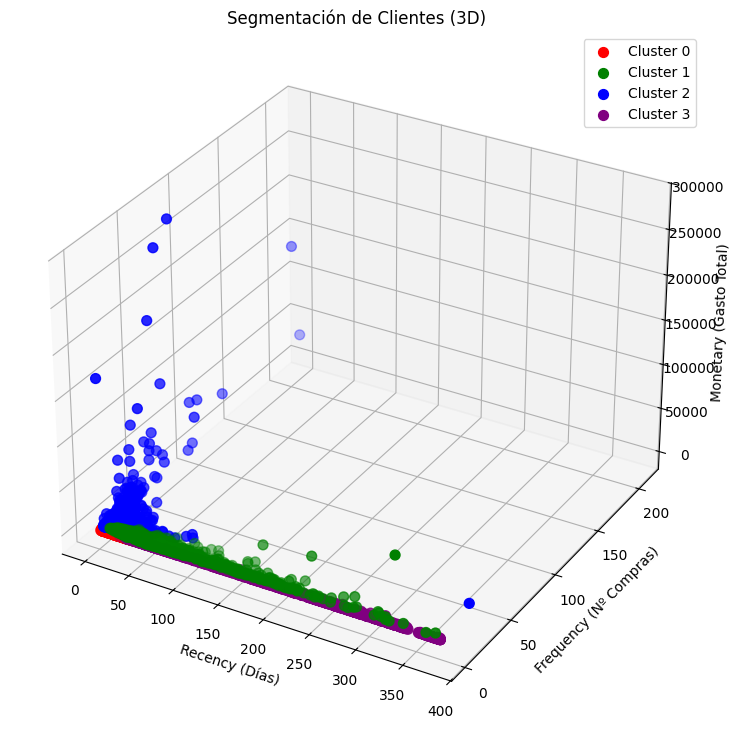

In [9]:
# --- Visualización 3D de los Clusters ---
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot para cada cluster
# Nota: Usamos los datos originales (rfm_df) para interpretar los ejes
ax.scatter(rfm_df[rfm_df['Cluster'] == 0]['Recency'],
           rfm_df[rfm_df['Cluster'] == 0]['Frequency'],
           rfm_df[rfm_df['Cluster'] == 0]['Monetary'],
           s=50, c='red', label='Cluster 0')

ax.scatter(rfm_df[rfm_df['Cluster'] == 1]['Recency'],
           rfm_df[rfm_df['Cluster'] == 1]['Frequency'],
           rfm_df[rfm_df['Cluster'] == 1]['Monetary'],
           s=50, c='green', label='Cluster 1')

ax.scatter(rfm_df[rfm_df['Cluster'] == 2]['Recency'],
           rfm_df[rfm_df['Cluster'] == 2]['Frequency'],
           rfm_df[rfm_df['Cluster'] == 2]['Monetary'],
           s=50, c='blue', label='Cluster 2')

ax.scatter(rfm_df[rfm_df['Cluster'] == 3]['Recency'],
           rfm_df[rfm_df['Cluster'] == 3]['Frequency'],
           rfm_df[rfm_df['Cluster'] == 3]['Monetary'],
           s=50, c='purple', label='Cluster 3')

ax.set_title('Segmentación de Clientes (3D)')
ax.set_xlabel('Recency (Días)')
ax.set_ylabel('Frequency (Nº Compras)')
ax.set_zlabel('Monetary (Gasto Total)')
ax.legend()
plt.show()

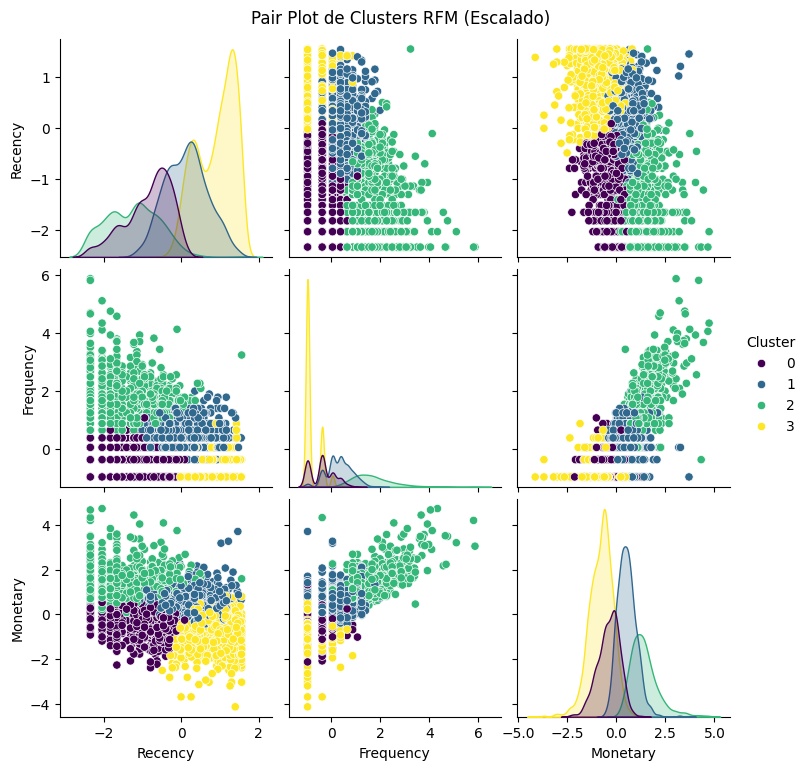

In [10]:
# --- Visualización Pairplot (2D) ---
# Usamos el DataFrame escalado aquí para una mejor distribución visual
# (aunque los datos originales también funcionan)
sns.pairplot(rfm_scaled_df, hue='Cluster', palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot de Clusters RFM (Escalado)', y=1.02)
plt.show()

**Análisis de Clusters e Insights**
El paso final es analizar las características promedio de RFM para cada clúster y asignarles etiquetas descriptivas. Esto nos permite proponer estrategias de negocio.

In [11]:
# --- Análisis de Características por Cluster ---

# Calcular la media de RFM para cada cluster
# Usamos el DataFrame original (rfm_df) para obtener valores interpretables (ej. días, dólares)
cluster_analysis = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Contar cuántos clientes hay en cada cluster
cluster_analysis['N_Clientes'] = rfm_df['Cluster'].value_counts().sort_index().values

# Reordenar columnas para mayor claridad
cluster_analysis = cluster_analysis[['Cluster', 'N_Clientes', 'Recency', 'Frequency', 'Monetary']]

print("--- Análisis de Centroides de Cluster (Promedios) ---")
print(cluster_analysis.to_markdown(index=False, floatfmt=",.2f"))

--- Análisis de Centroides de Cluster (Promedios) ---
|   Cluster |   N_Clientes |   Recency |   Frequency |   Monetary |
|----------:|-------------:|----------:|------------:|-----------:|
|      0.00 |       836.00 |     18.07 |        2.15 |     551.13 |
|      1.00 |     1,169.00 |     70.63 |        4.11 |   1,811.85 |
|      2.00 |       712.00 |     12.09 |       13.76 |   8,101.94 |
|      3.00 |     1,621.00 |    182.07 |        1.32 |     346.66 |
